In [4]:
import sys
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import argparse
from multiprocessing import Pool
from superneuromat.neuromorphicmodel import NeuromorphicModel
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
class GraphData():
    def __init__(self, name, config):
        self.name = name
        self.config = config
        self.paper_to_topic = {} # maps the paper ID in the dataset to its topic ID
        self.index_to_paper = []    # creates an index for each paper
        self.topics = []            # the list of topics 
        self.train_papers = []
        self.validation_papers = []
        self.test_papers = []
        self.load_topics()
        self.train_val_test_split()
        self.load_features()
        self.load_graph()

    def load_topics(self):
        if (self.name == "cora"):
            f = open("data/Cora/group-edges.csv", 'r')
            lines = f.readlines()
            f.close()

            for line in lines:
                fields = line.strip().split(",")
                if (fields[1] not in self.topics):
                    self.topics.append(fields[1])
                self.paper_to_topic[fields[0]] = fields[1]
                self.index_to_paper.append(fields[0])
        elif (self.name == "citeseer"):
            f = open("data/citeseer/citeseer.content", 'r')
            lines = f.readlines()
            f.close()

            for line in lines:
                fields = line.strip().split()
                if (fields[-1] not in self.topics):
                    self.topics.append(fields[-1])
                print(fields[0])
                self.paper_to_topic[fields[0]] = fields[-1]
                self.index_to_paper.append(fields[0])   
        elif (self.name == "pubmed"):
            f = open("data/Pubmed-Diabetes/data/Pubmed-Diabetes.NODE.paper.tab", 'r')
            lines = f.readlines()
            f.close()
            lines = lines[2:]
        
            for line in lines:
                fields = line.strip().split()
                if (fields[1] not in self.topics):
                    self.topics.append(fields[1])
                self.paper_to_topic["paper:"+fields[0]] = fields[1]
                self.index_to_paper.append("paper:"+fields[0])

    def load_features(self):
        self.features = {} # keyed on paper ID, value is the feature vector
        if (self.name == "cora"):
            f = open("data/Cora/cora/cora.content", 'r')
            lines = f.readlines()
            f.close()
            
            for line in lines:
                fields = line.strip().split()
                paper_id = fields[0]
                feature = [int(x) for x in fields[1:-1]]
                self.features[paper_id] = feature
                self.num_features = len(feature)
        elif (self.name == "citeseer"):
            f = open("data/citeseer/citeseer.content", 'r')
            lines = f.readlines()
            f.close()
            for line in lines:
                fields = line.strip().split()
                paper_id = fields[0]
                feature = [int(x) for x in fields[1:-1]]
                self.features[paper_id] = feature
                self.num_features = len(feature)
            print("NUM PAPERS WITH FEATURES: ", len(self.features.keys()))
        elif (self.name == "pubmed"):
            f = open("data/Pubmed-Diabetes/data/Pubmed-Diabetes.NODE.paper.tab", 'r')
            lines = f.readlines()
            f.close()
            feature_line = lines[1]
            fields = feature_line.split()
            fields = fields[1:-1]
            all_features = {}
            for i in range(len(fields)):
                feat = fields[i].split(':')[1]
                all_features[feat] = i

            self.num_features = len(all_features.keys())
            lines = lines[2:]
            for line in lines:
                feature = [0]*self.num_features
                fields = line.split()
                paper_id = "paper:" + fields[0]
                xfields = fields[-1].split('=')
                xfields = xfields[1].split(',')
                for x in xfields:
                    feature[all_features[x]] = 1
                self.features[paper_id] = feature

        self.paper_to_features = {} # keyed on paper ID, value is the number of features it has
        self.feature_to_papers = {} # keyed on feature ID, value is the number of papers that have that feature
        for p in self.features.keys():
            self.paper_to_features[p] = np.sum(self.features[p])
            for i in range(len(self.features[p])):
                if (i not in self.feature_to_papers.keys()):
                    self.feature_to_papers[i] = 0
                self.feature_to_papers[i] += self.features[p][i]
 
    def load_graph(self):
        if (self.name == "cora"):
            self.graph = nx.read_edgelist("data/Cora/edges.csv", delimiter=",")

        elif (self.name == "citeseer"):
            self.graph = nx.read_edgelist("data/citeseer/citeseer.cites")

        elif (self.name == "pubmed"):
            self.graph = nx.read_edgelist("data/Pubmed-Diabetes/data/edge_list.csv", delimiter=",")

    def train_val_test_split(self):
        np.random.seed(self.config["seed"])
        train_papers = []
        test_papers = []
        validation_papers = []
        check_breakdown = {}
        
        for k in self.topics:
            check_breakdown[k] = 0
        
        while (len(train_papers) < len(self.topics)*20):
            index = np.random.randint(len(self.index_to_paper))
            topic = self.paper_to_topic[self.index_to_paper[index]]
            if (check_breakdown[topic] < 20 and self.index_to_paper[index] not in train_papers):
                train_papers.append(self.index_to_paper[index])
                check_breakdown[topic] += 1
        
        while (len(validation_papers) < len(self.topics)*20):
            index = np.random.randint(len(self.index_to_paper))
            topic = self.paper_to_topic[self.index_to_paper[index]]
            if (check_breakdown[topic] < 40 and self.index_to_paper[index] not in train_papers and self.index_to_paper[index] not in validation_papers):
                validation_papers.append(self.index_to_paper[index])
                check_breakdown[topic] += 1
        
        for i in range(len(self.index_to_paper)):
            if (self.index_to_paper[i] not in train_papers and self.index_to_paper[i] not in validation_papers and self.index_to_paper[i] in self.paper_to_topic.keys()):
                test_papers.append(self.index_to_paper[i])

        self.train_papers = train_papers
        self.test_papers = test_papers
        self.validation_papers = validation_papers 

def print_paper_spikes(model, paper_neurons):
    """
    Print which paper neurons spiked at each time step, 
    assuming model.spike_train[t] is a binary array 
    indicating spike (1) or no spike (0) for each neuron.
    """
    for t, spike_array in enumerate(model.spike_train):
        # 'spike_array' is presumably something like [0, 1, 0, 0, 1, ...]
        spiking_papers = []
        for paper_id, neuron_id in paper_neurons.items():
            # Check if the value at index 'neuron_id' is 1 (i.e., a spike)
            if spike_array[neuron_id] == 1:
                spiking_papers.append(neuron_id)

        if spiking_papers:
            print(f"Time {t}: Paper Neurons that spiked: {spiking_papers}")


def load_network(graph, config):
    from superneuromat.neuromorphicmodel import NeuromorphicModel
    import numpy as np

    # Initialize the Neuromorphic Model
    model = NeuromorphicModel()

    # Dictionaries to hold neurons
    topic_neurons = {}
    paper_neurons = {}
    feature_neurons = {}

    # Create topic neurons
    for t in graph.topics:
        neuron = model.create_neuron(threshold=config["topic_threshold"])
        topic_neurons[t] = neuron
        # Assuming additional parameters can be set directly
        neuron.tau_m = config["topic_leak"]
        neuron.V_m = 0
        neuron.V_reset = 0
        neuron.E_L = 0
        neuron.tau_minus = config["topic_tau_minus"]

    # Create paper neurons
    for node in graph.graph.nodes:
        if node not in graph.paper_to_topic:
            continue
        neuron = model.create_neuron(threshold=config["paper_threshold"])
        paper_neurons[node] = neuron
        neuron.tau_m = config["paper_leak"]
        neuron.V_m = 0
        neuron.V_reset = 0
        neuron.E_L = 0
        neuron.tau_minus = config["paper_tau_minus"]

        # Set refractory periods based on paper type
        if node in graph.train_papers:
            neuron.t_ref = config["train_ref"]
        elif node in graph.validation_papers:
            neuron.t_ref = config["validation_ref"]
        elif node in graph.test_papers:
            neuron.t_ref = config["test_ref"]

    # Create feature neurons if features are enabled
    if config["features"] == 1:
        for i in range(graph.num_features):
            neuron = model.create_neuron(threshold=config["feature_threshold"])
            feature_neurons[i] = neuron
            neuron.tau_m = config["feature_leak"]
            neuron.V_m = 0
            neuron.V_reset = 0
            neuron.E_L = 0
            neuron.tau_minus = config["feature_tau_minus"]
            neuron.t_ref = config["feature_ref"]

    # Connect paper neurons based on the graph edges
    for edge in graph.graph.edges:
        if edge[0] not in paper_neurons or edge[1] not in paper_neurons:
            continue
        pre = paper_neurons[edge[0]]
        post = paper_neurons[edge[1]]
        variation_scale = 0.01

        w = config["graph_weight"]
        w *= (1.0 + np.random.normal(0, variation_scale))
        d = int(config["graph_delay"])
        model.create_synapse(pre, post, weight=w, delay=d, enable_stdp=False)
        model.create_synapse(post, pre, weight=w, delay=d, enable_stdp=False)

    # Connect training papers to topics
    for paper in graph.train_papers:
        paper_neuron = paper_neurons[paper]
        topic_neuron = topic_neurons[graph.paper_to_topic[paper]]
        variation_scale = 0.01

        w = config["train_to_topic_weight"]
        w *= (1.0 + np.random.normal(0, variation_scale))
        d = int(config["train_to_topic_delay"])
        model.create_synapse(paper_neuron, topic_neuron, weight=w, delay=d, enable_stdp=False)
        model.create_synapse(topic_neuron, paper_neuron, weight=w, delay=d, enable_stdp=False)

    # Connect validation papers to topics with STDP
    for paper in graph.validation_papers:
        for topic in graph.topics:
            paper_neuron = paper_neurons[paper]
            topic_neuron = topic_neurons[topic]
            variation_scale = 0.01

            w = config["validation_to_topic_weight"]
            w *= (1.0 + np.random.normal(0, variation_scale))
            d = int(config["validation_to_topic_delay"])
            model.create_synapse(
                paper_neuron, topic_neuron,
                weight=w, delay=d, enable_stdp=True
            )
            model.create_synapse(
                topic_neuron, paper_neuron,
                weight=w, delay=d, enable_stdp=True
            )

    # Connect test papers to topics with STDP
    for paper in graph.test_papers:
        for topic in graph.topics:
            paper_neuron = paper_neurons[paper]
            topic_neuron = topic_neurons[topic]
            variation_scale = 0.01 

            w = config["test_to_topic_weight"]
            w *= (1.0 + np.random.normal(0, variation_scale))
            d = int(config["test_to_topic_delay"])
            model.create_synapse(
                paper_neuron, topic_neuron,
                weight=w, delay=d, enable_stdp=True
            )
            model.create_synapse(
                topic_neuron, paper_neuron,
                weight=w, delay=d, enable_stdp=True
            )

    # Connect features to paper neurons if features are enabled
    if config["features"] == 1:
        for node in graph.graph.nodes:
            if node not in graph.features:
                print("No features for node: ", node)
                continue
            for i in range(len(graph.features[node])):
                if graph.features[node][i] == 1:
                    paper_neuron = paper_neurons[node]
                    feature_neuron = feature_neurons[i]
                    variation_scale = 0.01

                    w = config["paper_to_feature_weight"]
                    w *= (1.0 + np.random.normal(0, variation_scale))
                    d = int(config["paper_to_feature_delay"])
                    stdp_on = config["paper_to_feature_stdp"]
                    model.create_synapse(
                        paper_neuron, feature_neuron,
                        weight=w, delay=d, enable_stdp=stdp_on
                    )
                    model.create_synapse(
                        feature_neuron, paper_neuron,
                        weight=w, delay=d, enable_stdp=stdp_on
                    )

    return model, paper_neurons, topic_neurons, feature_neurons

def load_network(graph, config):

    # Initialize the Neuromorphic Model
    model = NeuromorphicModel()

    # Dictionaries to hold neuron IDs
    topic_neurons = {}
    paper_neurons = {}
    feature_neurons = {}

    # Create paper neurons
    for node in graph.graph.nodes:
        if (node not in graph.paper_to_topic.keys()):
            continue
        neuron_id = model.create_neuron(
            threshold=config["paper_threshold"],
            leak=config["paper_leak"],
            reset_state=0.0,
            refractory_period=0,  # Will set below based on paper type
        )
        paper_neurons[node] = neuron_id

        # Set refractory periods based on paper type
        if node in graph.train_papers:
            model.neuron_refractory_periods[neuron_id] = config["train_ref"]
        elif node in graph.validation_papers:
            model.neuron_refractory_periods[neuron_id] = config["validation_ref"]
        elif node in graph.test_papers:
            model.neuron_refractory_periods[neuron_id] = config["test_ref"]

    # Create topic neurons
    for t in graph.topics:
        neuron_id = model.create_neuron(
            threshold=config["topic_threshold"],
            leak=config["topic_leak"],
            reset_state=0.0,
            refractory_period=0, 
        )
        topic_neurons[t] = neuron_id
        # Setting tau_minus is not directly supported

    # Create feature neurons if features are enabled
    if config["features"] == 1:
        for i in range(graph.num_features):
            neuron_id = model.create_neuron(
                threshold=config["feature_threshold"],
                leak=config["feature_leak"],
                reset_state=0.0,
                refractory_period=config["feature_ref"],
            )
            feature_neurons[i] = neuron_id

    # Connect paper neurons based on the graph edges
    for edge in graph.graph.edges:
        if (edge[0] not in graph.paper_to_topic.keys() or edge[1] not in graph.paper_to_topic.keys()):
            continue
        pre_id = paper_neurons[edge[0]]
        post_id = paper_neurons[edge[1]]
        variation_scale = 0.01

        w = config["graph_weight"]
        w *= (1.0 + np.random.normal(0, variation_scale))
        d = int(config["graph_delay"])
        model.create_synapse(pre_id, post_id, weight=w, delay=d, enable_stdp=False)
        model.create_synapse(post_id, pre_id, weight=w, delay=d, enable_stdp=False)

    # Connect training papers to topics
    for paper in graph.train_papers:
        paper_id = paper_neurons[paper]
        topic_id = topic_neurons[graph.paper_to_topic[paper]]
        variation_scale = 0.01 

        w = config["train_to_topic_weight"]
        w *= (1.0 + np.random.normal(0, variation_scale))
        d = int(config["train_to_topic_delay"])
        model.create_synapse(paper_id, topic_id, weight=w, delay=d, enable_stdp=False)
        model.create_synapse(topic_id, paper_id, weight=w, delay=d, enable_stdp=False)

    # Connect validation papers to topics with STDP
    for paper in graph.validation_papers:
        paper_id = paper_neurons[paper]
        for topic in graph.topics:
            topic_id = topic_neurons[topic]
            variation_scale = 0.01 

            w = config["validation_to_topic_weight"]
            w *= (1.0 + np.random.normal(0, variation_scale))
            d = int(config["validation_to_topic_delay"])
            stdp_on = True
            model.create_synapse(
                paper_id, topic_id, weight=w, delay=d, enable_stdp=stdp_on
            )
            model.create_synapse(
                topic_id, paper_id, weight=w, delay=d, enable_stdp=stdp_on
            )

    # Connect test papers to topics with STDP
    for paper in graph.test_papers:
        paper_id = paper_neurons[paper]
        for topic in graph.topics:
            topic_id = topic_neurons[topic]
            variation_scale = 0.01 

            w = config["test_to_topic_weight"]
            w *= (1.0 + np.random.normal(0, variation_scale))
            d = int(config["test_to_topic_delay"])
            stdp_on = True
            model.create_synapse(
                paper_id, topic_id, weight=w, delay=d, enable_stdp=stdp_on
            )
            model.create_synapse(
                topic_id, paper_id, weight=w, delay=d, enable_stdp=stdp_on
            )

    # Connect features to paper neurons if features are enabled
    if config["features"] == 1:
        for node in graph.graph.nodes:
            if (node not in graph.features.keys()):
                print("No features for node: ", node)
                continue
            paper_id = paper_neurons[node]
            for i, feature_value in enumerate(graph.features[node]):
                if feature_value == 1:
                    feature_id = feature_neurons[i]
                    variation_scale = 0.01

                    w = config["paper_to_feature_weight"]
                    w *= (1.0 + np.random.normal(0, variation_scale))
                    d = int(config["paper_to_feature_delay"])
                    stdp_on = config["paper_to_feature_stdp"]
                    # Adjust weights if weighted connections are enabled
                    if config.get("paper_to_feature_weighted", False):
                        w_paper_to_feature = (
                            config["paper_to_feature_weight"]
                            * graph.paper_to_features[node]
                            / len(graph.features[node])
                        )
                        w_feature_to_paper = (
                            config["feature_to_paper_weight"]
                            * graph.feature_to_papers[i]
                            / len(graph.features)
                        )
                    else:
                        w_paper_to_feature = w
                        w_feature_to_paper = w

                    # Create synapses
                    model.create_synapse(
                        paper_id,
                        feature_id,
                        weight=w_paper_to_feature,
                        delay=d,
                        enable_stdp=stdp_on,
                    )
                    model.create_synapse(
                        feature_id,
                        paper_id,
                        weight=w_feature_to_paper,
                        delay=d,
                        enable_stdp=stdp_on,
                    )

    return model, paper_neurons, topic_neurons, feature_neurons

def test_paper(x):
    paper = x[0]    # paper ID of the paper you want to test
    graph = x[1]    # loaded graph
    config = x[2]   # config parameters

    # Load the network
    model, paper_neurons, topic_neurons, feature_neurons = load_network(graph, config)

    # Add a spike to the test paper neuron at time step 1 with a value sufficient to trigger a spike
    test_paper_id = paper_neurons[paper]
    model.add_spike(0, test_paper_id, value=config.get("input_spike_value", 100.0))

    correct_topic_label = graph.paper_to_topic[paper]  # e.g. "Neural_Nets"
    correct_topic_id = topic_neurons[correct_topic_label]
    #model.add_spike(1, correct_topic_id, value=100.0)

    # Determine the number of time steps for STDP
    simtime = int(config.get("simtime", 20)) 
    time_steps = int(config.get("stdp_time_steps", simtime))

    # Set up STDP parameters if not already set
    if not model.stdp:
        apos_value = config.get("stdp_Apos", 0.1)
        aneg_value = config.get("stdp_Aneg", 0.0001)

        # Create lists of Apos and Aneg values with length equal to time_steps
        Apos = [apos_value] * time_steps
        Aneg = [aneg_value] * time_steps
        model.stdp_setup(
            time_steps=time_steps,
            Apos=Apos,
            Aneg=Aneg,
            positive_update=True,
            negative_update=True,
        )

    # Prepare the model for simulation
    model.setup()

    # Simulate the model
    model.simulate(time_steps=simtime)
    #print("Printing", test_paper_id, correct_topic_id)
    #print_paper_spikes(model, topic_neurons)

    
    # Analyze the weights between the test paper neuron and topic neurons
    #min_weight = float('inf')
    min_weight = -100
    min_topic = None
    predicted_topic = None
    for topic, topic_id in topic_neurons.items():
        # Find the synapse from topic neuron to test paper neuron
        synapse_indices = [
            i for i, (pre, post) in enumerate(zip(model.pre_synaptic_neuron_ids, model.post_synaptic_neuron_ids))
            #if pre == topic_id and post == test_paper_id
            if pre == test_paper_id and post == topic_id
        ]
        if synapse_indices:
            idx = synapse_indices[0]
            weight = model.synaptic_weights[idx]
            print(f"Topic: {topic}, Paper: {paper}, Weight: {weight}")
            if weight > min_weight:
                min_weight = weight
                min_topic = topic
                predicted_topic = topic

    # Determine if the predicted topic matches the actual topic
    actual_topic = graph.paper_to_topic[paper]
    retval = 1 if actual_topic == min_topic else 0
    if retval == 1:
        print(f"MIN VAL for {paper} Topic {min_topic} CORRECT")
    else:
        print(f"MIN VAL for {paper} Topic {min_topic} WRONG, Expected {actual_topic}")

    # Optionally, plot the weights
    if config.get("monitors", False):
        weights = []
        topics = []
        for topic, topic_id in topic_neurons.items():
            synapse_indices = [
                i for i, (pre, post) in enumerate(zip(model.pre_synaptic_neuron_ids, model.post_synaptic_neuron_ids))
                if pre == topic_id and post == test_paper_id
            ]
            if synapse_indices:
                idx = synapse_indices[0]
                weights.append(model.synaptic_weights[idx])
                topics.append(topic)
        plt.bar(topics, weights)
        plt.xlabel('Topics')
        plt.ylabel('Weights')
        plt.title('Weights from Topic Neurons to Test Paper Neuron')
        plt.show()

    #return retval
    return (paper, predicted_topic, retval)

def evaluate_network(graph, test_papers, get_predicted_topic_for_paper):
    true_labels = []
    pred_labels = []

    for paper in test_papers:
        true_label = graph.paper_to_topic[paper]
        predicted_label = get_predicted_topic_for_paper(paper)  # your code here
        true_labels.append(true_label)
        pred_labels.append(predicted_label)

    # Unique topics used
    topics_list = list(set(true_labels + pred_labels))

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=topics_list)
    print("Confusion Matrix:")
    print(cm)

    # Classification report
    report = classification_report(true_labels, pred_labels, labels=topics_list, target_names=topics_list)
    print("\nClassification Report:")
    print(report)

    # Optional: plot confusion matrix
    plot_confusion_matrix(cm, topics_list)

def plot_confusion_matrix(cm, labels):
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="black")

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def evaluate_predictions(graph, predictions):
    """
    Build true_labels and pred_labels from 'predictions', then print confusion matrix and classification report.
    """
    true_labels = []
    pred_labels = []
    
    for (paper, predicted_topic, _) in predictions:
        actual_topic = graph.paper_to_topic[paper]
        true_labels.append(actual_topic)
        pred_labels.append(predicted_topic)
    
    # Unique set of topics encountered
    all_topics = list(set(true_labels + pred_labels))
    
    cm = confusion_matrix(true_labels, pred_labels, labels=all_topics)
    print("Confusion Matrix:\n", cm)
    
    report = classification_report(true_labels, pred_labels, labels=all_topics, target_names=all_topics)
    print("\nClassification Report:\n", report)
    
    # Optionally, plot confusion matrix:
    plot_confusion_matrix(cm, all_topics)

def plot_confusion_matrix(cm, labels):
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
    
    # Print numeric values in the cells
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Topic: Rule_Learning, Paper: 683360, Weight: 1.1831936422915914
Topic: Neural_Networks, Paper: 683360, Weight: 1.2833043842952443
Topic: Case_Based, Paper: 683360, Weight: 1.2832998680298808
Topic: Genetic_Algorithms, Paper: 683360, Weight: 1.1832008363705702
Topic: Theory, Paper: 683360, Weight: 1.2832994328362584
Topic: Reinforcement_Learning, Paper: 683360, Weight: 1.2832917690353383
Topic: Probabilistic_Methods, Paper: 683360, Weight: 0.8828937828772476
Topic: Rule_Learning, Paper: 34257, Weight: 1.5835677435233626
MIN VAL for 683360 Topic Neural_Networks WRONG, Expected Probabilistic_MethodsTopic: Neural_Networks, Paper: 34257, Weight: 1.483481113447522

Topic: Case_Based, Paper: 34257, Weight: 1.1831996940883285
Topic: Genetic_Algorithms, Paper: 34257, Weight: 1.3833950557269814
Topic: Theory, Paper: 34257, Weight: 1.5836281103613368
Topic: Reinforcement_Learning, Paper: 34257, Weight: 1.3834069449709219
Topic: Probabilistic_Methods, Paper: 34257, Weight: 1.2832866326938204
MIN V

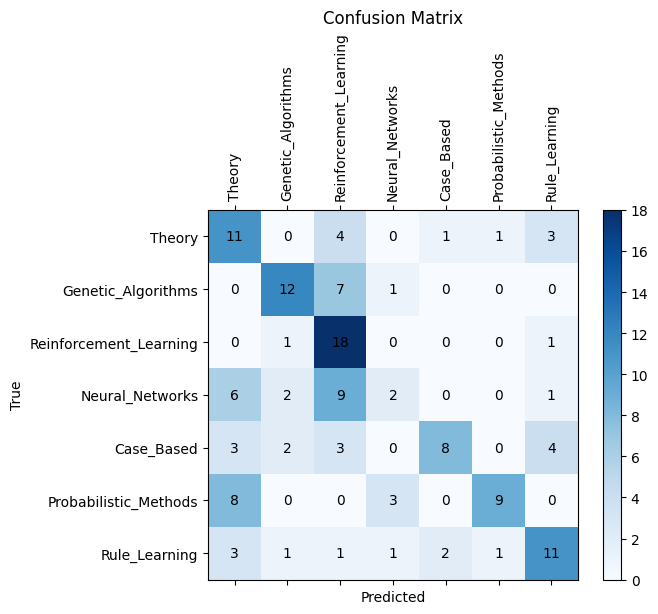

In [6]:
if "ipykernel_launcher" in sys.argv[0]:
    # Filter out Jupyter-specific arguments
    sys.argv = [sys.argv[0]] + [arg for arg in sys.argv[1:] if not arg.startswith("--f=")]
    sys.argv += ["--dataset", "cora", "--mode", "validation"]


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description="GNN-SNN")
    parser.add_argument("--dataset", "-d", type=str, choices=["cora", "citeseer", "pubmed"], required=True)
    parser.add_argument("--mode", "-m", type=str, choices=["validation", "test"], required=True)
    parser.add_argument("--seed", "-s", type=int, default=0)
    parser.add_argument("--features", type=int, choices=[0,1])
    parser.add_argument("--paper_leak", type=float, default=100000.0)           # [1., 10., 100., 100000.] 
    parser.add_argument("--paper_threshold", type=float, default=1.0)          # [0.25, 0.5, 0.75, 1.0, 1.5]
    parser.add_argument("--paper_tau_minus", type=float, default=30.)           # [5., 10., 15., 20., 25., 30., 40., 50.]
    parser.add_argument("--train_ref", type=float, default=1.0)                 # [1.0, 5.0, 10.0, 100.0, 1000.0]
    parser.add_argument("--feature_ref", type=float, default=1.0)                 # [1.0, 5.0, 10.0, 100.0, 1000.0]
    parser.add_argument("--validation_ref", type=float, default=1000.0)         # [1.0, 5.0, 10.0, 100.0, 1000.0]

    # NOTE: We probably want to keep this parameter the same as the validation parameter above
    parser.add_argument("--test_ref", type=float, default=1000.0)               # [1.0, 5.0, 10.0, 100.0, 1000.0]
    parser.add_argument("--topic_leak", type=float, default=100000.0)           # [1., 10., 100., 100000.] 
    parser.add_argument("--topic_threshold", type=float, default=.5)            # [0.25, 0.5, 0.75, 1.0, 1.5]
    parser.add_argument("--topic_tau_minus", type=float, default=30.)           # [5., 10., 15., 20., 25., 30., 40., 50.]
    parser.add_argument("--feature_leak", type=float, default=100000.0)         # [1., 10., 100., 100000.] 
    parser.add_argument("--feature_threshold", type=float, default=0.25)       # [0.25, 0.5, 0.75, 1.0, 1.5]
    parser.add_argument("--feature_tau_minus", type=float, default=30.0)        # [5., 10., 15., 20., 25., 30., 40., 50.]
    parser.add_argument("--graph_weight", type=float, default=10.0)            # [0.5, 1.0, 10.0, 100.0]            
    parser.add_argument("--graph_delay", type=float, default=1.0)               # [1., 2., 5., 10., 20.]
    parser.add_argument("--train_to_topic_weight", type=float, default=1.0)     # [0.5, 1.0, 10.0, 100.0]
    parser.add_argument("--train_to_topic_delay", type=float, default=1.0)      # [1., 2., 5., 10., 20.]
    parser.add_argument("--validation_to_topic_weight", type=float, default=0.001)  # [0.001, 0.005, 0.01, 0.05, 0.1]
    parser.add_argument("--validation_to_topic_delay", type=float, default=1.0)     # [1., 2., 5., 10., 20.]
    parser.add_argument("--validation_to_topic_alpha", type=float, default=1.0)     # [0.5, 1.0, 2.0, 5.0]
    parser.add_argument("--validation_to_topic_tau_plus", type=float, default=30.0) # [5., 10., 15., 20., 25., 30., 40., 50.]

    # NOTE: We probably want to keep these parameters the same as the validation set parameters
    parser.add_argument("--test_to_topic_weight", type=float, default=0.001)    # [0.001, 0.005, 0.01, 0.05, 0.1]
    parser.add_argument("--test_to_topic_delay", type=float, default=1.0)       # [1., 2., 5., 10., 20.]
    parser.add_argument("--test_to_topic_alpha", type=float, default=1.0)       # [0.5, 1.0, 2.0, 5.0]
    parser.add_argument("--test_to_topic_tau_plus", type=float, default=30.0)   # [5., 10., 15., 20., 25., 30., 40., 50.]
    parser.add_argument("--paper_to_feature_weight", type=float, default=0.2)   # [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    parser.add_argument("--feature_to_paper_weight", type=float, default=0.2)   # [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    parser.add_argument("--paper_to_feature_delay", type=float, default=4.0)    # [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
    parser.add_argument("--paper_to_feature_alpha", type=float, default=1.0)    # [0.5, 1.0, 2.0, 5.0]
    parser.add_argument("--paper_to_feature_tau_plus", type=float, default=30.0)    # [5., 10., 15., 20., 25., 30., 40., 50.]
    parser.add_argument("--simtime", type=float, default=20.0)                  # [5., 10., 20., 30., 40., 50. 75., 100., 150., 200.]
    parser.add_argument("--processes", type=int, default=4)         # Change this depending on your machine
    parser.add_argument("--monitors", type=str, default="False")
    parser.add_argument("--paper_to_feature_stdp", type=str, default="False")
    parser.add_argument("--paper_to_feature_weighted", type=str, default="False")

    args = parser.parse_args()

    config = vars(args)

    if (config["monitors"] == "True" or config["monitors"] == "true"):
        config["monitors"] = True
    else:
        config["monitors"] = False

    if (config["paper_to_feature_stdp"] == "True" or config["paper_to_feature_stdp"] == "true"):
        config["paper_to_feature_stdp"] = True
    else:
        config["paper_to_feature_stdp"] = False
    
    if (config["paper_to_feature_weighted"] == "True" or config["paper_to_feature_weighted"] == "true"):
        config["paper_to_feature_weighted"] = True
    else:
        config["paper_to_feature_weighted"] = False

    np.random.seed(args.seed) 
    graph = GraphData(args.dataset, config)    
    
    if (config["monitors"] == True):
        for i in range(0, len(graph.validation_papers), 20):
            paper = graph.validation_papers[i]
            x = [paper, graph, config]
            test_paper(x)
        sys.exit()

     # Spike each of the test papers in simulation
    i = 0
    correct = 0
    total = 0

    pool = Pool(args.processes)
    if args.mode == "validation":
        papers = []
        for paper in graph.validation_papers:
            papers.append([paper, graph, config])
    
        # predictions will be a list of tuples: (paper, predicted_topic, retval)
        predictions = pool.map(test_paper, papers)
    
        # You already print accuracy using retval
        accuracy = np.mean([ret for (_, _, ret) in predictions])
        print("Validation Accuracy:", accuracy)

        # Evaluate with confusion matrix, classification report, etc.
        evaluate_predictions(graph, predictions)
 
    if args.mode == "test":
        papers = []
        for paper in graph.test_papers:
            papers.append([paper, graph, config])
        x = pool.map(test_paper, papers) 
        print("Testing Accuracy:", np.sum(x) / len(graph.test_papers))
